In [1]:
import matplotlib.pyplot as plt
from torch.autograd import Variable
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from sklearn.metrics import f1_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix,accuracy_score 
from sklearn.metrics import classification_report

#### Two cells given below import google drive as a folder to colab environment. 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
!unzip "/content/drive/My Drive/MNIST_Data.zip"
# !unzip -uq "/content/drive/My Drive/MNIST_Data.zip" -d "/content/drive/My Drive/MNIST_data"

Streaming output truncated to the last 5000 lines.
  inflating: train/9/1821.png        
  inflating: train/9/18212.png       
  inflating: train/9/18229.png       
  inflating: train/9/18242.png       
  inflating: train/9/18252.png       
  inflating: train/9/1827.png        
  inflating: train/9/18278.png       
  inflating: train/9/18297.png       
  inflating: train/9/18351.png       
  inflating: train/9/18356.png       
  inflating: train/9/18375.png       
  inflating: train/9/18378.png       
  inflating: train/9/18383.png       
  inflating: train/9/18388.png       
  inflating: train/9/184.png         
  inflating: train/9/18402.png       
  inflating: train/9/18406.png       
  inflating: train/9/18416.png       
  inflating: train/9/18438.png       
  inflating: train/9/18442.png       
  inflating: train/9/18449.png       
  inflating: train/9/18459.png       
  inflating: train/9/18476.png       
  inflating: train/9/18501.png       
  inflating: train/9/18507.png       

## Tranforms and Dataloader


In [5]:
def loadDataset(data_dir,train_size,val_size,test_size,batch_sizee,shuffle):
    train_transforms = transforms.Compose([transforms.Resize((28,28)),transforms.Grayscale(),transforms.ToTensor(),
                                        transforms.Normalize([0.0],
                                                              [0.5])])

    test_transforms = transforms.Compose([transforms.Resize((28,28)),transforms.Grayscale(),transforms.ToTensor(),
                                          transforms.Normalize([0.0],
                                                              [0.5])])
    validation_transforms = transforms.Compose([transforms.Resize((28,28)),transforms.Grayscale(),transforms.ToTensor(),
                                          transforms.Normalize([0.0],
                                                              [0.5])])

    # Loading dataset using ImageFolder method. Pass transforms in here.
    train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
    test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

    # Here train and test dataloader are created using train_data and test_data objects. Batch size tells how many images are 
    # loaded for one iteration. 
    indices = np.arange(len(train_data))
    test_indices=np.arange(0,test_size)
    train_indices, val_indices = train_test_split(indices, train_size=train_size, stratify=train_data.targets)
    train_dataset = torch.utils.data.Subset(train_data, train_indices)
    val_dataset = torch.utils.data.Subset(train_data, val_indices)
    test_dataset=torch.utils.data.Subset(test_data,test_indices)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sizee, shuffle=shuffle)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_sizee, shuffle=shuffle)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_sizee)

    print("Training dataset size : ",len(train_loader.dataset))
    print("Validation dataset size : ",len(val_loader.dataset))
    print("Test dataset size : ", len(test_loader.dataset))
    return train_loader,val_loader,test_loader


## Declaring Neural Network


In [6]:
class init_network(nn.Module):

  def __init__(self, no_of_layers, input_dim, neurons_per_layer, dropout):
    super(init_network, self).__init__()
    
    self.drop_out = nn.Dropout(p=dropout)
    self.hidden = nn.ModuleList()
    self.hidden.append(nn.Linear(input_dim,neurons_per_layer[0]))
    for i in range(1,len(neurons_per_layer)):
        self.hidden.append(nn.Linear(neurons_per_layer[i-1],neurons_per_layer[i]))

# Prediction

  def forward(self, x):

    for (l, linear_model) in enumerate(self.hidden):
        if l < len(self.hidden) - 1:
            x = F.relu(linear_model(x))
            x = self.drop_out(x)
        else:
            x = linear_model(x)
            
    return F.log_softmax(x,dim=1)

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Training the Neural Network

In [32]:
def train(model, criterion, optimizer, train_loader, val_loader, epochs):
    model.to(device)
    data_for_visualization = {'training_loss': [], 'validation_loss': [], 'training_accuracy': [], 'validation_accuracy': []}
    for epoch in range(epochs):
        training_loss,training_accuracy, = 0.0,0.0
        validation_loss,validation_accuracy=0.0,0.0

        correct = 0
        model.train()

        for data, target in train_loader:
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)
            data = data.view(-1, 28*28)
            optimizer.zero_grad()
            net_out = model(data)
            loss = criterion(net_out, target)

            loss.backward() 
            optimizer.step()

            training_loss += loss.item()
            _, predicted = torch.max(net_out.data, 1)
            correct += (predicted == target).sum().item()
            
        training_accuracy = correct / len(train_loader.dataset)
        training_loss = training_loss / len(train_loader)
    
        with torch.no_grad():
            correct = 0
            model.eval()

            for data, target in val_loader: 
                data, target = Variable(data), Variable(target) 
                data, target = data.to(device), target.to(device)
                data = data.view(-1, 28*28)
                net_out = model(data)
                
                loss = criterion(net_out, target)
                validation_loss += loss.item()

                _, predicted = torch.max(net_out.data, 1)
                correct += (predicted == target).sum().item()

        validation_accuracy = correct / len(val_loader.dataset)
        validation_loss = validation_loss / len(val_loader)

        data_for_visualization['training_loss'].append(training_loss)
        data_for_visualization['validation_loss'].append(validation_loss)
        data_for_visualization['training_accuracy'].append(training_accuracy)
        data_for_visualization['validation_accuracy'].append(validation_accuracy)
        print(
            'Training Epoch: {} | Train Loss: {:.3f} | Validation Loss: {:.3f} | '
            'Train Accuracy: {:.2f} | Validation Accuracy: {:.2f}'.format(
                epoch,training_loss, validation_loss, training_accuracy, validation_accuracy))
        

    return data_for_visualization, model

In [33]:
# this line of code saves the trained model to google drive.
def save_model(model,path):
  torch.save(model.state_dict(), path)


In [34]:
# this loads the saved model from the given directory.
def load_model(path):
  model.load_state_dict(torch.load(path))
  return model

In [41]:
# this code cell calculates accuracy of test data on the trained model.
def test(model,test_loader,criterion):
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = Variable(data), Variable(target)
          data, target = data.to(device), target.to(device)

          data = data.view(-1, 28*28*1)
          net_out = model(data)
          # sum up batch loss
          test_loss += criterion(net_out, target).item()
          pred = net_out.data.max(1)[1]  # get the index of the max log-probability
          correct += pred.eq(target.data).sum()

      test_loss /= len(test_loader.dataset)
      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))
      return pred

In [42]:
def data_extraction(model, loader):
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for data in loader:
            data, target = data
            data = data.to(device)
            data=data.view(-1, 28 * 28)
            net_out = model(data)
            _, predicted = torch.max(net_out.data, 1) 
                
            y_pred.append(predicted.cpu().detach().numpy())
            y_true.append(target)
            
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    
    return y_pred, y_true

In [43]:
  def Reports(y_pred, y_true):
    print("F1_score on testing data : ",f1_score(y_pred, y_true,average=None))
    print("confusion_matrix : ")
    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_true,y_pred))
    plt.show()
    print("classification_report : ",classification_report(y_true,y_pred))
    print("Accuracy score on testing data : ",accuracy_score(y_pred, y_true)*100)

In [44]:
def visualization(visualization_data):
    fig, ax = plt.subplots(1, 2, figsize=(25, 5))

    ax[0].plot(visualization_data['training_accuracy'], label='Training dataset Accuracy')
    ax[0].plot(visualization_data['validation_accuracy'], label='Validation dataset Accuracy')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation datset Accuracy Graph')
    ax[0].legend()

    ax[1].plot(visualization_data['training_loss'], label='Training dataset Loss')
    ax[1].plot(visualization_data['validation_loss'], label='Validation dataset Loss')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Cross Entropy Loss')
    ax[1].set_title('Training and Validation dataset Losses Graph')
    ax[1].legend()
    plt.show()

In [53]:
def sample_images(model,train_loader,sample_img_index):
  for data in train_loader:
              data, target = data
              d1=data
              data = data.to(device)
              data=data.view(-1, 28 * 28)
              net_out = model(data)
              _, predicted = torch.max(net_out.data, 1) 
              predicted=predicted.cpu().detach().numpy()
              data=data.cpu().detach().numpy()
              break

  for i in sample_img_index:
    print("Prediction : ",predicted[i])
    plt.imshow(d1[i].resize(28,28))
    plt.show()

In [54]:
def main(path,train_size,val_size,test_size,no_of_hidden_layers,hid_neurons,loss_function,optimizer,batch_size,learning_rate,drop_out,is_training,device,epochs,model_path):
  shuffle=True
  print("Name : Sohaib Ali Gill")
  print("Roll No : MSDS-19050")
  print("No of hidden layers: ",no_of_hidden_layers)
  print("batch size",batch_size)
  print("Learning rate : ", learning_rate)
  print("No of Epochs : " ,epochs)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
  train_loader,val_loader,test_loader= loadDataset(path,train_size,val_size,test_size,batch_size,shuffle)
  model=init_network(no_of_hidden_layers,784,hid_neurons,drop_out)
  model.to(device)
  print(model)
  if is_training==True:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = nn.CrossEntropyLoss()
    visualization_data,model=train(model,loss_function,optimizer,train_loader,val_loader,epochs)
    save_model(model,model_path)
  else :
    model=load_model(model_path)
  pred=test(model,test_loader,loss_function)
  y_pred, y_true=data_extraction(model,test_loader)
  Reports(y_pred,y_true)
  visualization(visualization_data)
  sample_images(model,train_loader,[2,5,7])


Name : Sohaib Ali Gill
Roll No : MSDS-19050
No of hidden layers:  3
batch size 192
Learning rate :  0.005
No of Epochs :  10
Training dataset size :  50000
Validation dataset size :  10000
Test dataset size :  10000
init_network(
  (drop_out): Dropout(p=0.2, inplace=False)
  (hidden): ModuleList(
    (0): Linear(in_features=784, out_features=700, bias=True)
    (1): Linear(in_features=700, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)
Training Epoch: 0 | Train Loss: 1.421 | Validation Loss: 0.480 | Train Accuracy: 0.58 | Validation Accuracy: 0.87
Training Epoch: 1 | Train Loss: 0.455 | Validation Loss: 0.314 | Train Accuracy: 0.87 | Validation Accuracy: 0.91
Training Epoch: 2 | Train Loss: 0.333 | Validation Loss: 0.244 | Train Accuracy: 0.90 | Validation Accuracy: 0.93
Training Epoch: 3 | Train Loss: 0.264 | Validation Loss: 0.205 | Train Accuracy: 0.92 | Validation Accuracy

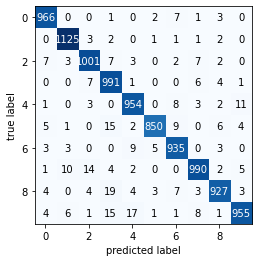

classification_report :                precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.94      0.98      0.96      1010
           4       0.96      0.97      0.97       982
           5       0.99      0.95      0.97       892
           6       0.96      0.98      0.97       958
           7       0.97      0.96      0.97      1028
           8       0.97      0.95      0.96       974
           9       0.98      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Accuracy score on testing data :  96.94


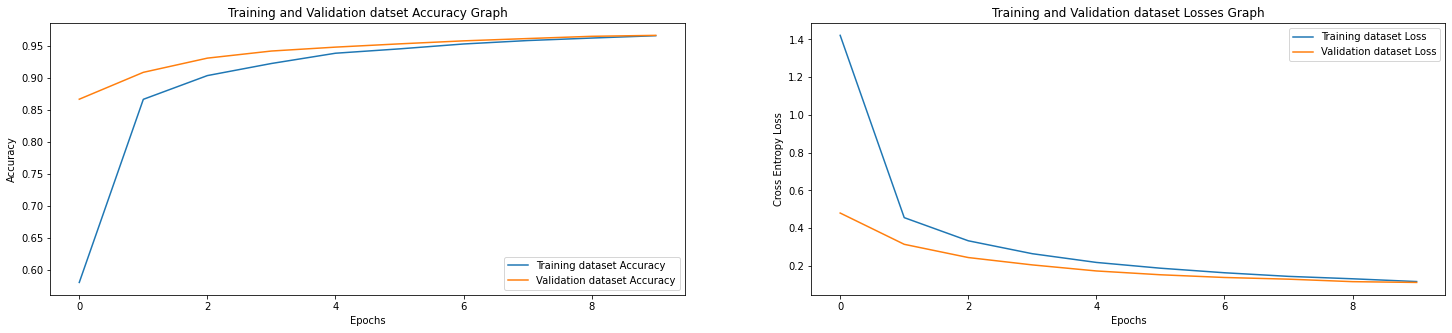

Prediction :  5


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


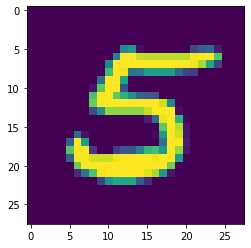

Prediction :  0


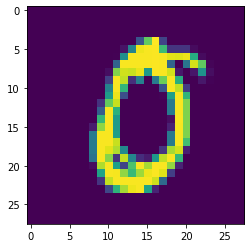

Prediction :  1


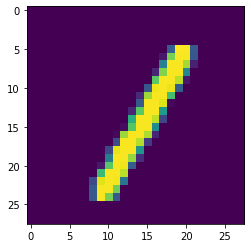

In [55]:
main(path='/content/', 
     train_size = 50000, val_size = 10000, test_size = 10000, 
     no_of_hidden_layers = 3, 
     hid_neurons = [700,500,100, 10], 
     loss_function = 'cross entropy', 
     optimizer = 'SGD', 
     batch_size = 192, 
     learning_rate = 0.005,  
     drop_out = 0.2, 
     is_training = True,  
     device='cpu',
     epochs = 10,
     model_path="/content/train/weights.pth")